In [1]:
# !pip install xgboost

In [2]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

from keras import Model, Sequential
from keras.layers import Dense, Dropout
from keras.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import joblib
import xgboost as xgb
print("XGB Version:", xgb.__version__)

XGB Version: 2.0.0


In [3]:
# carregar os dados de entrada
inputs_file = 'input_db_29_08_2023_14_26_20.pkl'
with open(inputs_file, 'rb') as handle_inputs:
    inputs = pickle.load(handle_inputs)

In [4]:
inputs.head()

,site_lat,site_long,sat_long,freq,eirp,hsat,bw_total,bw_util,rolloff,mod,fec,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,35786,36,16.155547,0.2,32APSK,126/180,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,35786,36,22.226415,0.2,32APSK,135/180,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518
2,-19.167619,-34.986496,-2.622435,5.349325,56.252903,35786,36,35.827805,0.2,64APSK,162/180,19.590329,1.207189,0.530488,57.036432,28.600282,5.894995,1.506105
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,35786,36,14.203504,0.2,8PSK,100/180,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,35786,36,9.488156,0.2,32APSK,126/180,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052


In [5]:
inputs = inputs.drop(columns=["hsat", "bw_total", "mod", "fec", "rolloff"])

In [6]:
# carregar os dados de saída - 
# apenas a coluna availability é relevante para o problema, 
# pode-se ignorar as demais para o treinamento e teste
results_file = 'results_db_29_08_2023_14_26_20.pkl'
with open(results_file, 'rb') as handle_results:
    results = pickle.load(handle_results)

In [7]:
results.head()

,availability,a_fs,a_g,a_c,a_r,a_s,a_t,a_tot,a_depoint,c_n0,...,earth_radius,elevation_angle,distance,fig_merit,noise_ground,noise_sky,ant_noise,noise_total,ant_gain,ant_3db
0,99.904,207.841452,0.322924,0.966845,9.079432,0.526741,10.383000,220.241483,2.017030,84.759447,...,6367.489544,43.741256,37499.215397,24.276649,10.0,10.860506,260.815713,286.308799,43.398944,1.263074
1,99.999,201.903879,0.065287,0.201974,7.102761,0.439884,7.383255,277.812514,68.525380,112.688241,...,6367.489544,56.474767,36698.322584,95.134206,10.0,3.208548,235.351027,248.680367,46.873483,0.591097
2,96.460,198.393586,0.065097,0.039061,0.016178,0.116006,0.193583,201.164695,2.577525,-99916.332614,...,6367.489544,47.007765,37271.796260,-100000.000000,10.0,3.867110,25.687222,54.289160,33.854824,3.249709
3,99.999,206.567603,0.201870,0.712902,27.381892,0.930295,28.312062,241.951596,7.071931,86.145051,...,6367.489544,59.412644,36547.299501,23.855004,10.0,5.183472,284.602019,314.728183,39.509835,1.408672
4,99.990,207.986262,0.381950,1.032110,16.817812,0.716087,18.246230,232.308445,6.075953,82.544269,...,6367.489544,37.330831,37986.968867,26.033504,10.0,12.583786,281.070225,302.118263,43.249134,0.517240


In [8]:
# preprocessamento da base de dados - 
# as linhas cuja coluna fig_merit têm valor igual a -100000 
# são casos inválidos e devem ser removidos 
filter_matrix = results.fig_merit != -100000
print(filter_matrix.head())
print(np.sum(filter_matrix))

0     True
1     True
2    False
3     True
4     True
Name: fig_merit, dtype: bool
1457619


In [9]:
filtered_inputs = inputs[filter_matrix]
filtered_results = results[filter_matrix]

           site_lat     site_long      sat_long          freq          eirp  \
count  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean  -1.505471e+01 -5.330440e+01 -5.230916e+01  1.132981e+01  5.091215e+01   
std    1.061157e+01  1.080609e+01  3.258509e+01  4.041949e+00  1.763086e+01   
min   -3.368997e+01 -7.288998e+01 -1.079999e+02  3.000049e+00  1.500033e+01   
25%   -2.430390e+01 -6.240066e+01 -8.093161e+01  7.965716e+00  3.691857e+01   
50%   -1.470179e+01 -5.317498e+01 -5.223987e+01  1.150008e+01  5.183633e+01   
75%   -5.817384e+00 -4.398199e+01 -2.366515e+01  1.483480e+01  6.597661e+01   
max    2.819986e+00 -3.480004e+01  2.999920e+00  1.799999e+01  7.999994e+01   

            bw_util  snr_threshold      ant_size       ant_eff      lnb_gain  \
count  1.457619e+06   1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean   1.850569e+01   8.798743e+00  2.383836e+00  5.565397e-01  5.999881e+01   
std    1.009771e+01   5.843946e+00  1.251949e+00

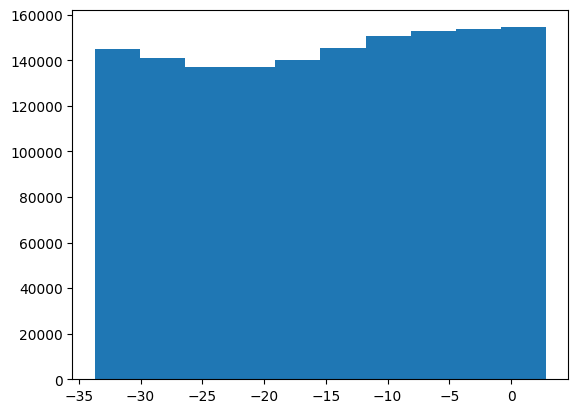

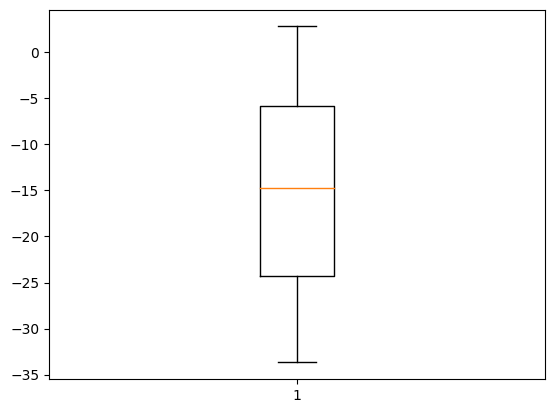

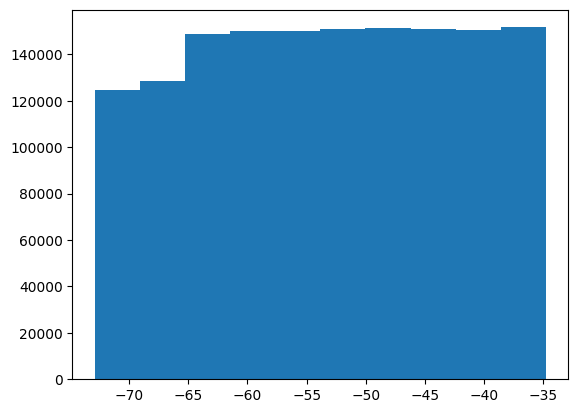

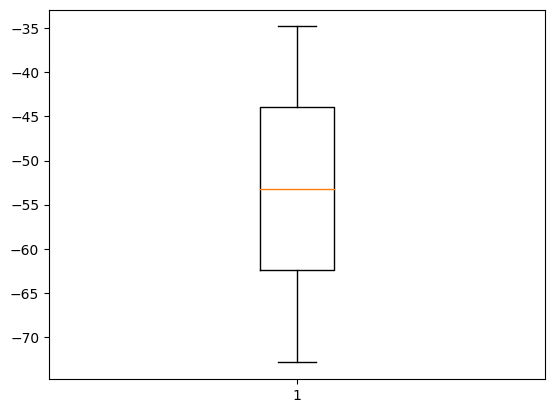

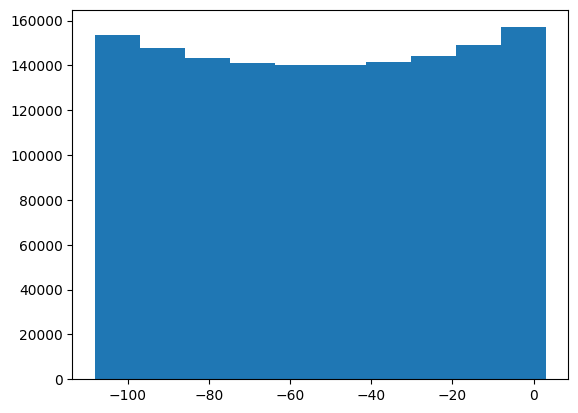

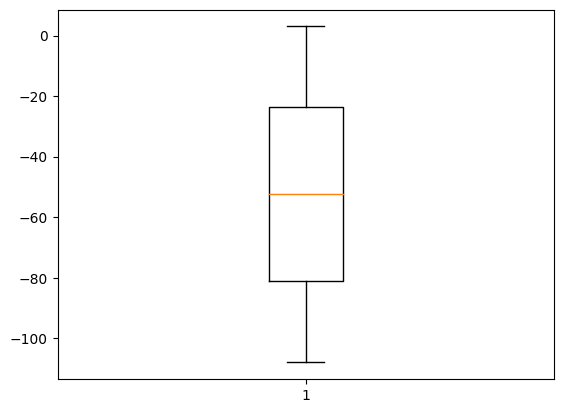

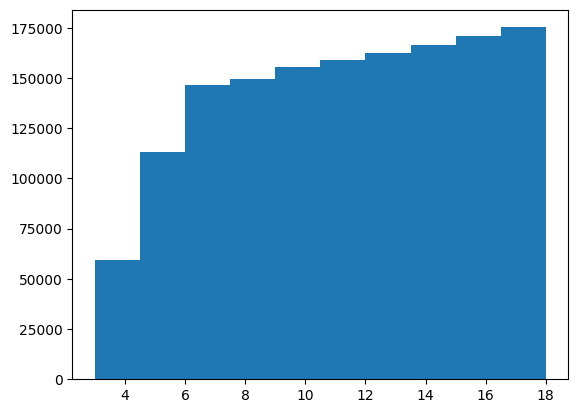

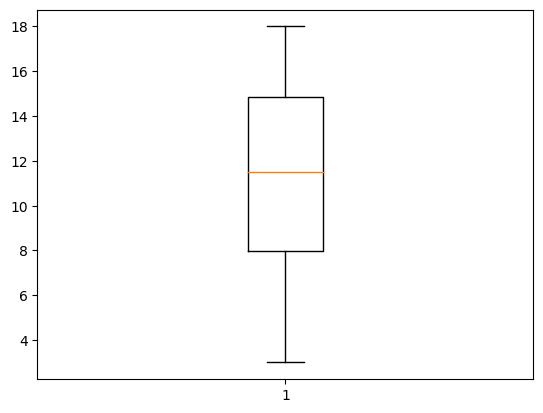

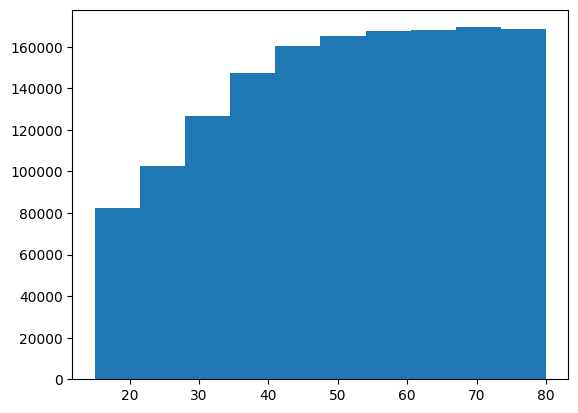

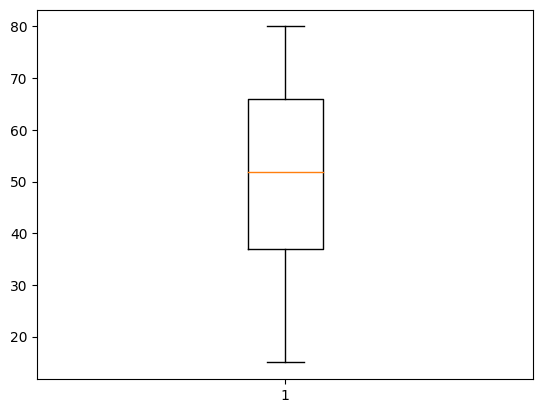

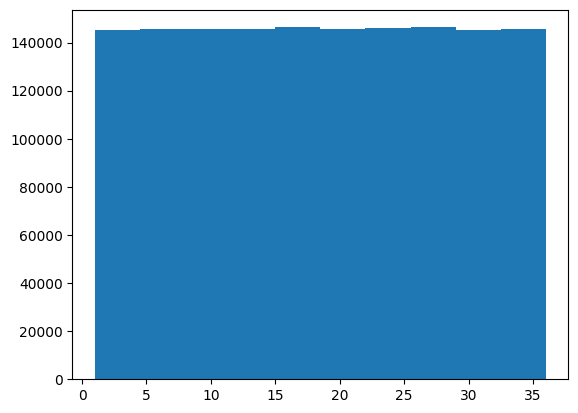

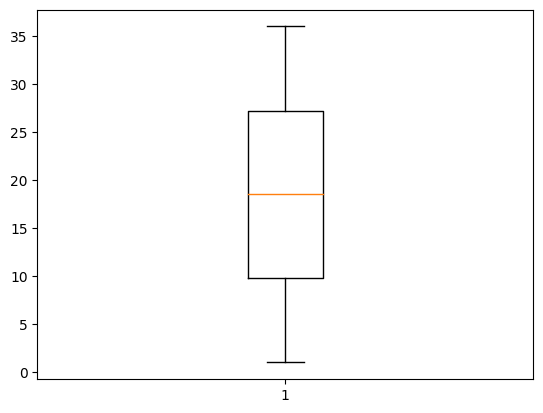

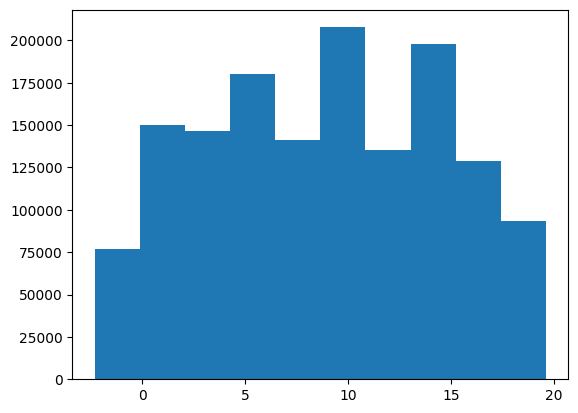

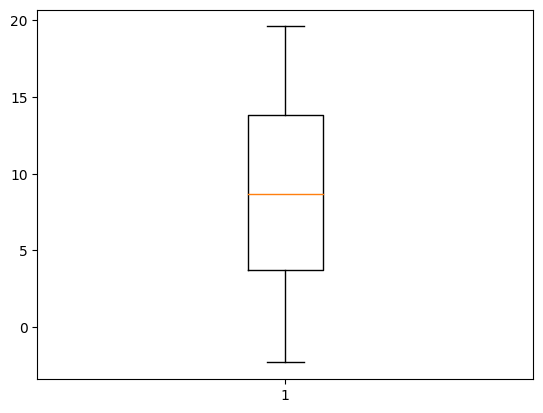

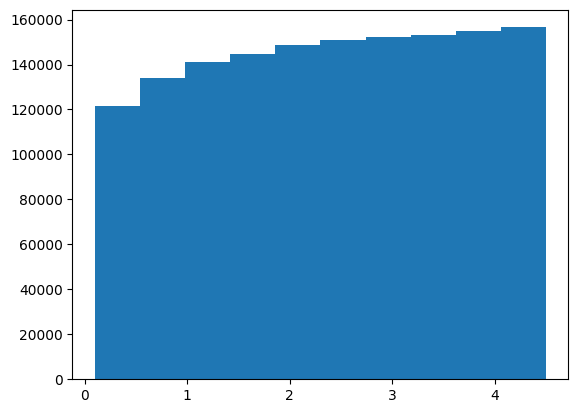

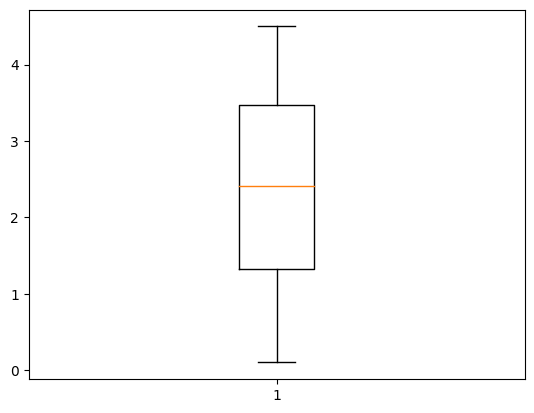

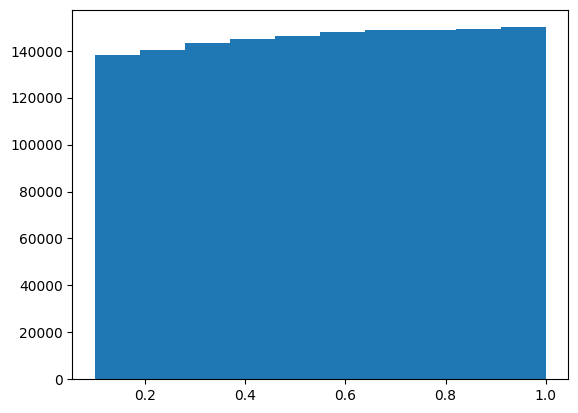

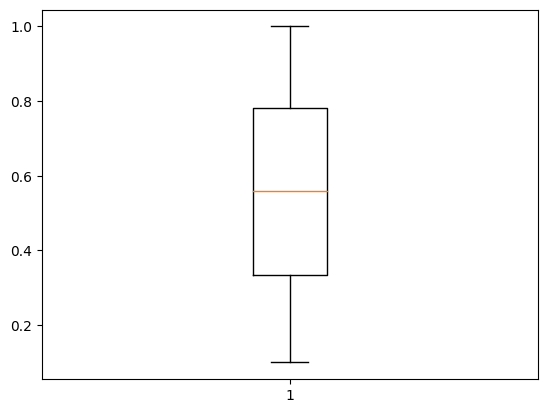

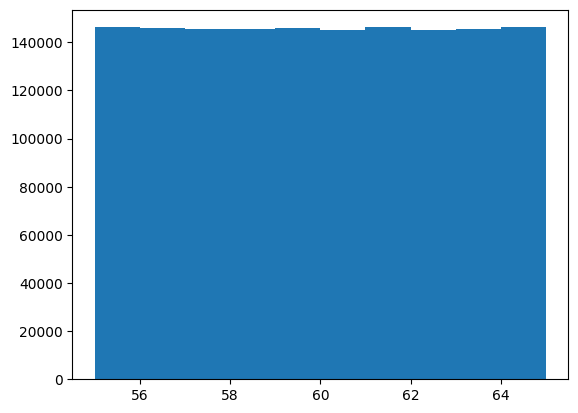

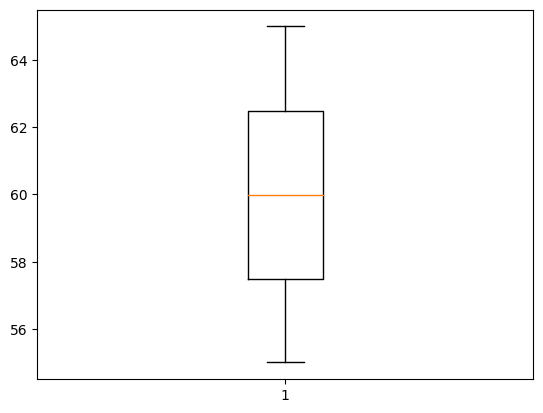

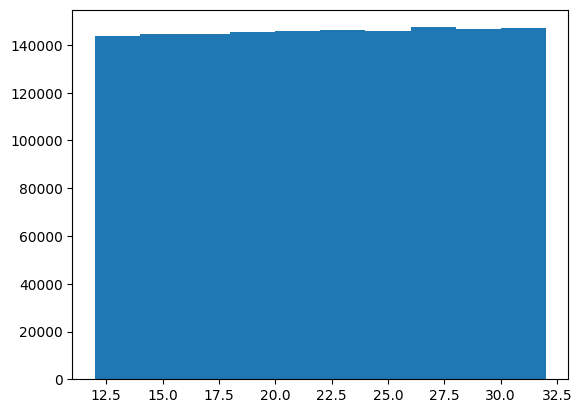

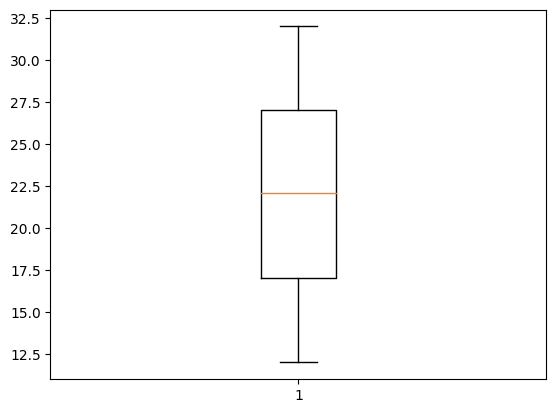

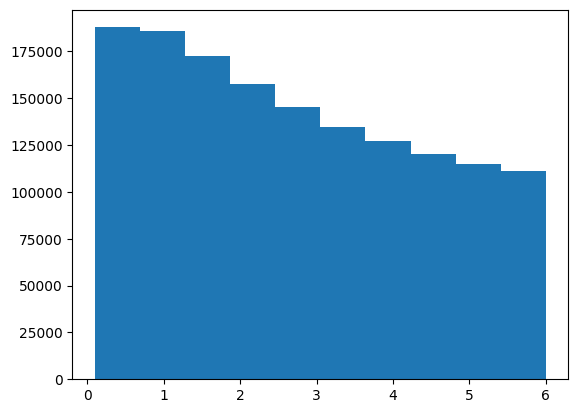

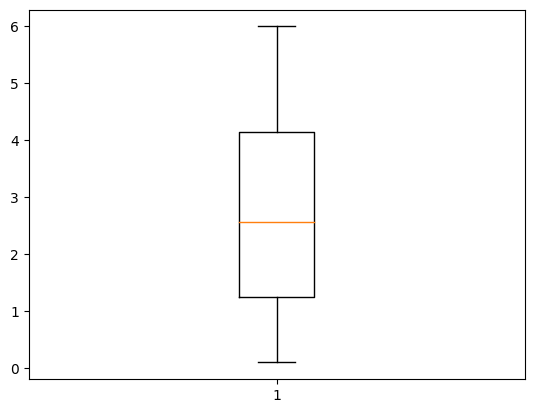

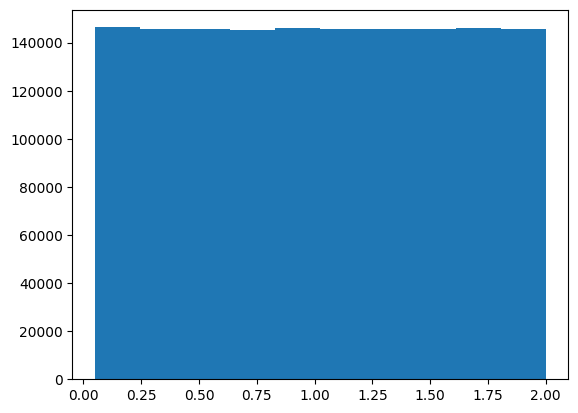

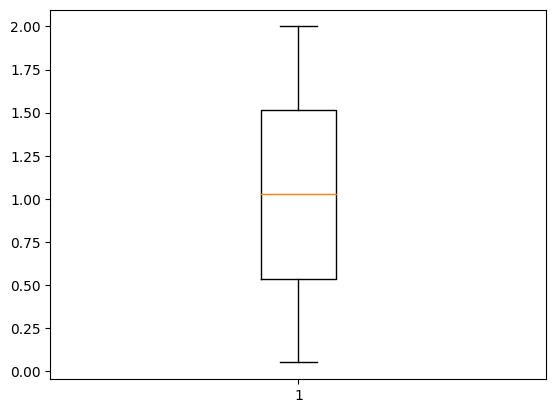

In [10]:
print(filtered_inputs.describe())
for column in inputs.columns:
    # Creating plot
    plt.hist(filtered_inputs[column])
    plt.show()
    plt.boxplot(filtered_inputs[column])
    plt.show()

In [11]:
filtered_results["availability"].describe()

count    1.457619e+06
mean     9.929238e+01
std      1.374950e+00
min      9.500000e+01
25%      9.964200e+01
50%      9.999200e+01
75%      9.999900e+01
max      9.999900e+01
Name: availability, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x30f478400>,
 'caps': [<matplotlib.lines.Line2D at 0x30f426470>,
 'boxes': [<matplotlib.lines.Line2D at 0x30f478310>],
 'medians': [<matplotlib.lines.Line2D at 0x30f424610>],
 'fliers': [<matplotlib.lines.Line2D at 0x30f4270a0>],
 'means': []}

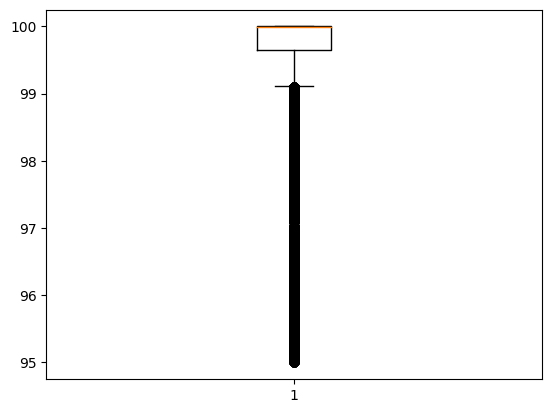

In [12]:
plt.boxplot(filtered_results["availability"])

(array([1.17000e+02, 1.43000e+02, 1.97000e+02, 2.01000e+02, 4.56000e+02,
        2.87000e+02, 3.21000e+02, 3.34000e+02, 6.35000e+02, 3.57000e+02,
        3.67000e+02, 3.93000e+02, 7.40000e+02, 3.59000e+02, 4.04000e+02,
        4.30000e+02, 7.46000e+02, 3.59000e+02, 4.23000e+02, 3.98000e+02,
        7.65000e+02, 3.63000e+02, 4.11000e+02, 3.57000e+02, 7.39000e+02,
        4.06000e+02, 3.83000e+02, 4.02000e+02, 6.89000e+02, 4.39000e+02,
        4.02000e+02, 3.95000e+02, 7.55000e+02, 4.18000e+02, 3.94000e+02,
        4.01000e+02, 7.20000e+02, 4.17000e+02, 3.95000e+02, 4.33000e+02,
        7.08000e+02, 3.88000e+02, 3.76000e+02, 4.02000e+02, 7.64000e+02,
        3.99000e+02, 4.09000e+02, 3.98000e+02, 7.66000e+02, 3.49000e+02,
        4.01000e+02, 3.84000e+02, 7.36000e+02, 3.44000e+02, 2.29000e+03,
        1.49900e+03, 2.83600e+03, 1.46600e+03, 1.43900e+03, 1.47200e+03,
        2.79600e+03, 1.45200e+03, 1.52800e+03, 1.47600e+03, 2.79600e+03,
        1.46300e+03, 1.50700e+03, 1.54100e+03, 2.91

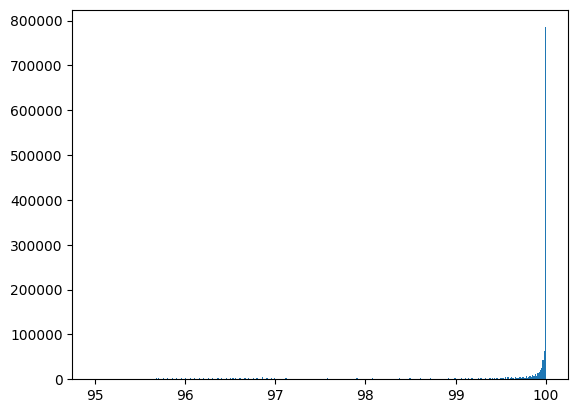

In [13]:
plt.hist(filtered_results["availability"], bins=400)

In [14]:
df = filtered_inputs.assign(availability=filtered_results["availability"])
df.head()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,16.155547,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839,99.904
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,22.226415,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518,99.999
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,14.203504,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404,99.999
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,9.488156,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052,99.990
5,-17.303467,-41.668725,-66.343144,12.480028,27.720772,31.814645,8.326742,4.452849,0.583401,64.208048,17.289375,2.862834,1.010339,99.554


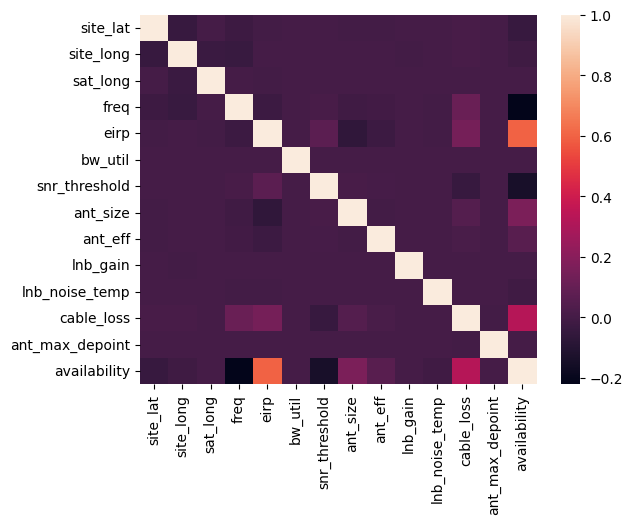

In [15]:
sns.heatmap(df.corr())
plt.show()

In [16]:
# setando a semente para divisão dos conjuntos de treino e teste
np.random.seed(0)

In [17]:
# separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(filtered_inputs, filtered_results['availability'], test_size=0.2)

In [18]:
# alguns dados estatisticos por atributo
x_train.describe()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
count,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06,1.166095e+06
mean,-1.505710e+01,-5.330025e+01,-5.232505e+01,1.132592e+01,5.091384e+01,1.849934e+01,8.801438e+00,2.383161e+00,5.564281e-01,5.999895e+01,2.204306e+01,2.734617e+00,1.025127e+00
std,1.060994e+01,1.080551e+01,3.258371e+01,4.042234e+00,1.763703e+01,1.009759e+01,5.843931e+00,1.251836e+00,2.587791e-01,2.888473e+00,5.773442e+00,1.692083e+00,5.633102e-01
min,-3.368997e+01,-7.288998e+01,-1.079999e+02,3.000049e+00,1.500033e+01,1.000003e+00,-2.297824e+00,1.000031e-01,1.000027e-01,5.500000e+01,1.200001e+01,1.000104e-01,5.000065e-02
25%,-2.430311e+01,-6.239452e+01,-8.093318e+01,7.959209e+00,3.690922e+01,9.765242e+00,3.744510e+00,1.319557e+00,3.340053e-01,5.750003e+01,1.704972e+01,1.250094e+00,5.364574e-01
50%,-1.470912e+01,-5.317090e+01,-5.227094e+01,1.149744e+01,5.184141e+01,1.849531e+01,8.670497e+00,2.410881e+00,5.593250e-01,5.999796e+01,2.206712e+01,2.559478e+00,1.025672e+00
75%,-5.822522e+00,-4.397547e+01,-2.369243e+01,1.482901e+01,6.598846e+01,2.723730e+01,1.382831e+01,3.467692e+00,7.805493e-01,6.249920e+01,2.704564e+01,4.145796e+00,1.513118e+00
max,2.819986e+00,-3.480004e+01,2.999885e+00,1.799997e+01,7.999990e+01,3.599999e+01,1.959033e+01,4.499999e+00,9.999982e-01,6.499999e+01,3.199995e+01,5.999996e+00,2.000000e+00


In [19]:
# normalização dos dados
preprocessParams = preprocessing.StandardScaler().fit(x_train)
x_train_normalized = preprocessParams.transform(x_train)
x_test_normalized = preprocessParams.transform(x_test)

In [20]:
y_train_normalized = np.log10(y_train)
y_test_normalized = np.log10(y_test)

(array([ 13548.,  42885.,  60055.,  61347.,   8796.,   8118.,  10722.,
         17101.,  43178., 900345.]),
 array([1.97772818, 1.97995492, 1.98218167, 1.98440842, 1.98663517,
        1.98886192, 1.99108866, 1.99331541, 1.99554216, 1.99776891,
        1.99999566]),
 <BarContainer object of 10 artists>)

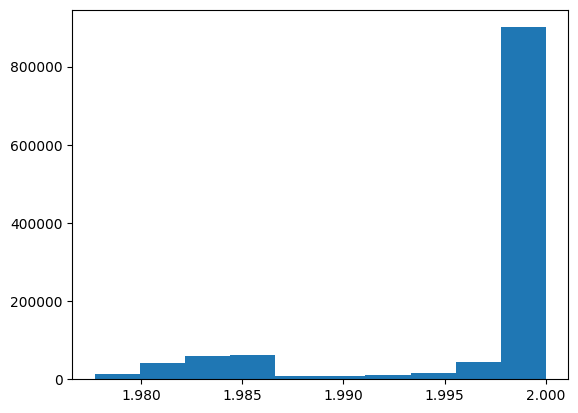

In [21]:
plt.hist(y_train_normalized)

(array([  3373.,  10436.,  15352.,  15330.,   2224.,   2019.,   2650.,
          4321.,  10670., 225149.]),
 array([1.97772361, 1.97995081, 1.98217802, 1.98440522, 1.98663243,
        1.98885963, 1.99108684, 1.99331404, 1.99554125, 1.99776845,
        1.99999566]),
 <BarContainer object of 10 artists>)

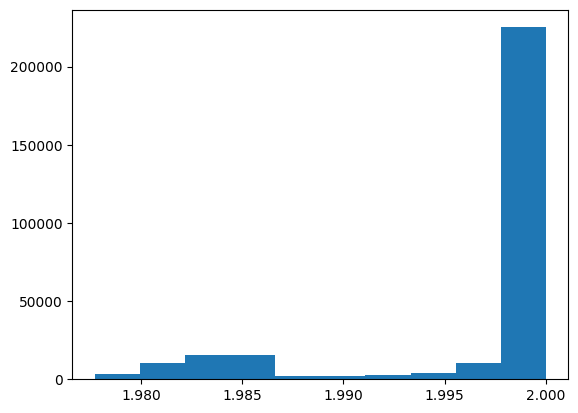

In [22]:
plt.hist(y_test_normalized)

In [23]:
x_train_normalized.shape[1:]

(13,)

In [24]:
feature_names = filtered_inputs.columns

In [25]:
# teste de outros modelos de IA
model1 = LinearRegression()
model1.fit(x_train_normalized, y_train_normalized)

LinearRegression()

In [26]:
model1.score(x_test_normalized, y_test_normalized)

0.5379966676125567

In [27]:
# Get the metrics on the validation data
predicted_availability1 = model1.predict(x_test_normalized)
mae1 = mean_absolute_error(y_test_normalized, predicted_availability1)
print('Linear test MAE = ', mae1)

Linear test MAE =  tf.Tensor(0.0033410043507418785, shape=(), dtype=float64)


In [28]:
mse1 = mean_squared_error(y_test_normalized, predicted_availability1)
rmse1 = mse1**.5
print('Linear test MSE = ', mse1)
print('Linear test RMSE = ', rmse1)

Linear test MSE =  tf.Tensor(1.7136659486609646e-05, shape=(), dtype=float64)
Linear test RMSE =  tf.Tensor(0.004139644850299316, shape=(), dtype=float64)


In [29]:
model2 = RandomForestRegressor()
model2.fit(x_train_normalized, y_train_normalized)

RandomForestRegressor()

In [30]:
# save model
joblib.dump(model2, "random_forest_logout.joblib")

['random_forest_logout.joblib']

In [31]:
model2.score(x_test_normalized, y_test_normalized)

0.9084746894935958

In [32]:
# Get the metrics on the validation data
predicted_availability2 = model2.predict(x_test_normalized)

In [33]:
mae2 = mean_absolute_error(y_test_normalized, predicted_availability2)
print('Random forest test MAE = ', mae2)

Random forest test MAE =  tf.Tensor(0.0007671168380102188, shape=(), dtype=float64)


In [34]:
mse2 = mean_squared_error(y_test_normalized, predicted_availability2)
rmse2 = mse2**.5
print('Random forest test MSE = ', mse2)
print('Random forest test RMSE = ', rmse2)

Random forest test MSE =  tf.Tensor(3.3948631332363403e-06, shape=(), dtype=float64)
Random forest test RMSE =  tf.Tensor(0.0018425154363631096, shape=(), dtype=float64)


In [35]:
params = model2.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

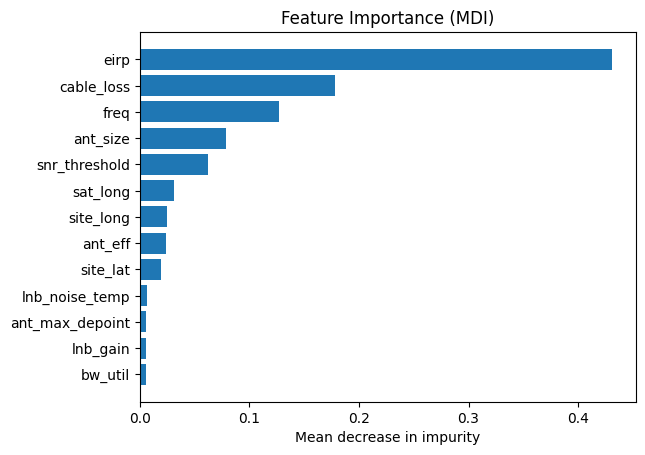

In [36]:
# obtain feature importance
feature_importance2 = model2.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance2)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance2[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

In [37]:
result2 = permutation_importance(
    model2, x_test_normalized, y_test_normalized, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances2 = pd.Series(result2.importances_mean, index=feature_names)

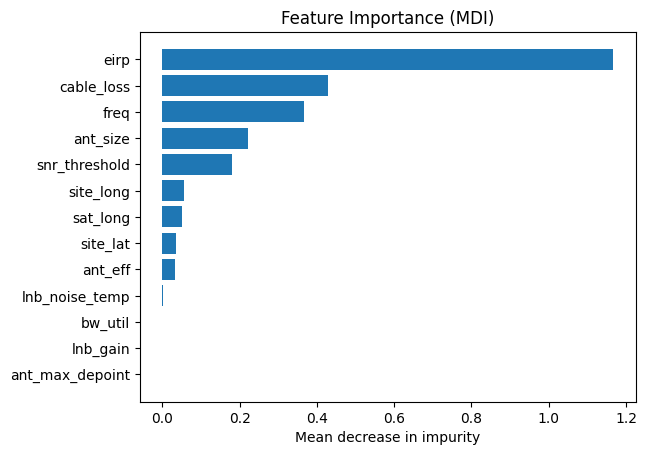

In [38]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances2)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances2[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

Text(0.5, 1.0, 'Permutation Importance (test set)')

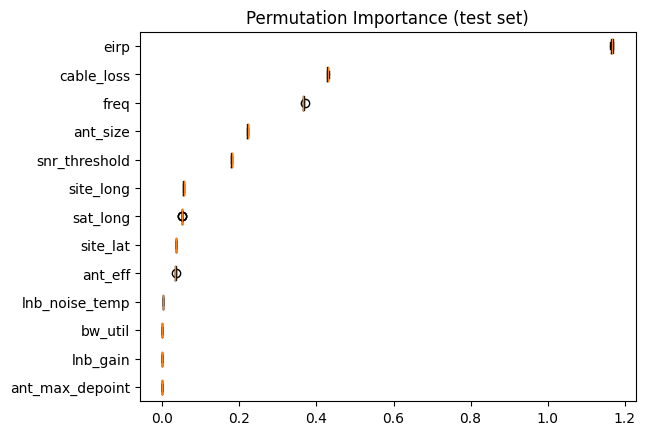

In [44]:
plt.boxplot(
    result2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

In [45]:
model3 = HistGradientBoostingRegressor()
model3.fit(x_train_normalized, y_train_normalized)

HistGradientBoostingRegressor()

In [46]:
# save model
joblib.dump(model3, "hist_grad_boost_logout.joblib")

['hist_grad_boost_logout.joblib']

In [47]:
model3.score(x_test_normalized, y_test_normalized)

0.8560082102572997

In [48]:
# Get the metrics on the validation data
predicted_availability3 = model3.predict(x_test_normalized)

In [49]:
mae3 = mean_absolute_error(y_test_normalized, predicted_availability3)
print('Hist. Grad. Boost. test MAE = ', mae3)

Hist. Grad. Boost. test MAE =  tf.Tensor(0.0011848550209031124, shape=(), dtype=float64)


In [50]:
mse3 = mean_squared_error(y_test_normalized, predicted_availability3)
rmse3 = mse3**.5
print('Hist. Grad. Boost. test MSE = ', mse3)
print('Hist. Grad. Boost. test RMSE = ', rmse3)

Hist. Grad. Boost. test MSE =  tf.Tensor(5.34095340164956e-06, shape=(), dtype=float64)
Hist. Grad. Boost. test RMSE =  tf.Tensor(0.0023110502810734256, shape=(), dtype=float64)


In [51]:
params = model3.get_params()
params

{'categorical_features': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'quantile': None,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [52]:
len(model3.train_score_) # é diferente de params["max_iter"]+1 : ???

65

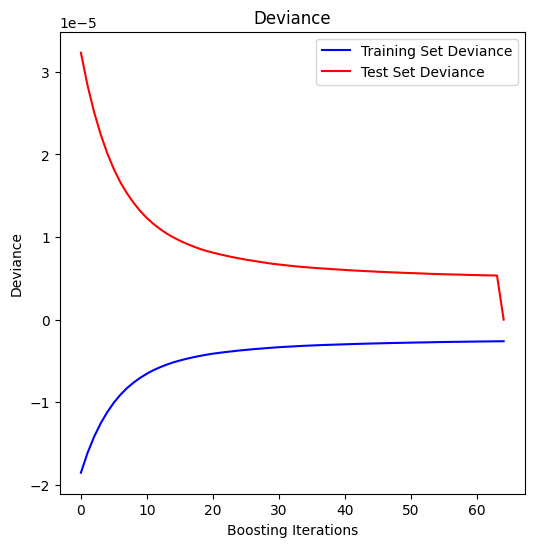

In [53]:
test_score = np.zeros((len(model3.train_score_),), dtype=np.float64)

for i, y_pred in enumerate(model3.staged_predict(x_test_normalized)):
    test_score[i] = mean_squared_error(y_test_normalized, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(len(model3.train_score_)),
    model3.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(len(model3.train_score_)), test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.show()

In [54]:
result3 = permutation_importance(
    model3, x_test_normalized, y_test_normalized, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances3 = pd.Series(result3.importances_mean, index=feature_names)

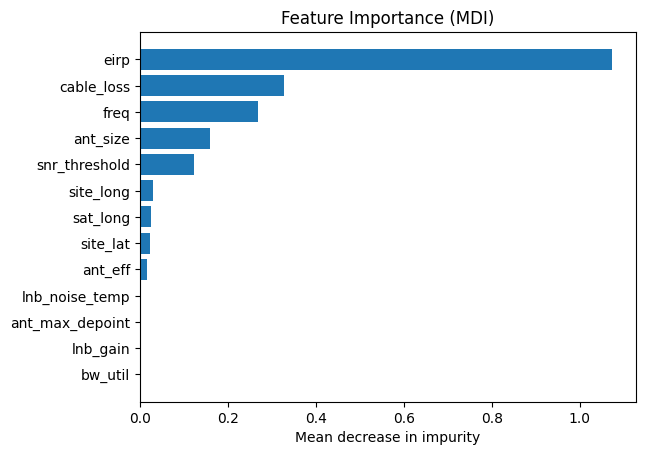

In [55]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances3)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances3[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

Text(0.5, 1.0, 'Permutation Importance (test set)')

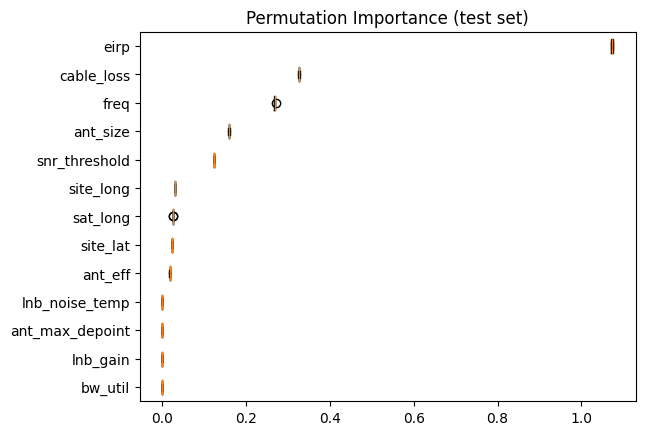

In [56]:
plt.boxplot(
    result3.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

In [57]:
eval_set = [(x_train_normalized, y_train_normalized), (x_test_normalized, y_test_normalized)]
model4 = xgb.XGBRegressor()
model4.fit(x_train_normalized, 
           y_train_normalized, 
           verbose=True,
           eval_set=eval_set)

[0]	validation_0-rmse:0.00487	validation_1-rmse:0.00487
[1]	validation_0-rmse:0.00407	validation_1-rmse:0.00407
[2]	validation_0-rmse:0.00356	validation_1-rmse:0.00357
[3]	validation_0-rmse:0.00323	validation_1-rmse:0.00324
[4]	validation_0-rmse:0.00301	validation_1-rmse:0.00303
[5]	validation_0-rmse:0.00287	validation_1-rmse:0.00288
[6]	validation_0-rmse:0.00277	validation_1-rmse:0.00278
[7]	validation_0-rmse:0.00269	validation_1-rmse:0.00271
[8]	validation_0-rmse:0.00263	validation_1-rmse:0.00265
[9]	validation_0-rmse:0.00258	validation_1-rmse:0.00260
[10]	validation_0-rmse:0.00254	validation_1-rmse:0.00256
[11]	validation_0-rmse:0.00251	validation_1-rmse:0.00253
[12]	validation_0-rmse:0.00248	validation_1-rmse:0.00250
[13]	validation_0-rmse:0.00246	validation_1-rmse:0.00248
[14]	validation_0-rmse:0.00244	validation_1-rmse:0.00246
[15]	validation_0-rmse:0.00243	validation_1-rmse:0.00245
[16]	validation_0-rmse:0.00242	validation_1-rmse:0.00244
[17]	validation_0-rmse:0.00240	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
# save model
joblib.dump(model4, "xgboost_logout.joblib")

['xgboost_logout.joblib']

In [59]:
results4 = model4.evals_result()
results4

{'validation_0': OrderedDict([('rmse',
               [0.00486673440797232,
                0.0040652834852382,
                0.00356065866569273,
                0.00323161628900435,
                0.00301357793180794,
                0.00286904121880563,
                0.00276810902548278,
                0.00269496442739703,
                0.00263473812659893,
                0.00257914351065206,
                0.00254182848380796,
                0.00251056800462399,
                0.00248173196561891,
                0.00246105188735678,
                0.00244258379617705,
                0.00242795488003879,
                0.00241653989821657,
                0.00240389278403868,
                0.00239460851391104,
                0.00237587451048732,
                0.00236472312237987,
                0.00235690800956846,
                0.00234329315901357,
                0.00233835406596834,
                0.00233250721117934,
                0.00232611749789535,


In [60]:
model4.score(x_test_normalized, y_test_normalized)

0.8850086847980202

In [61]:
# Get the metrics on the validation data
predicted_availability4 = model4.predict(x_test_normalized)

In [62]:
mae4 = mean_absolute_error(y_test_normalized, predicted_availability4)
print('XGBoost test MAE = ', mae4)

XGBoost test MAE =  tf.Tensor(0.0011354622, shape=(), dtype=float32)


In [63]:
mse4 = mean_squared_error(y_test_normalized, predicted_availability4)
rmse4 = mse4**.5
print('XGBoost test MSE = ', mse4)
print('XGBoost test RMSE = ', rmse4)

XGBoost test MSE =  tf.Tensor(4.2652573e-06, shape=(), dtype=float32)
XGBoost test RMSE =  tf.Tensor(0.00206525, shape=(), dtype=float32)


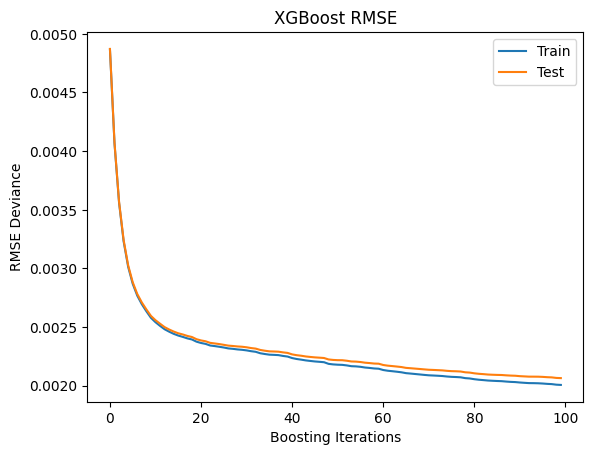

In [64]:
epochs = len(results4['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results4['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results4['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");

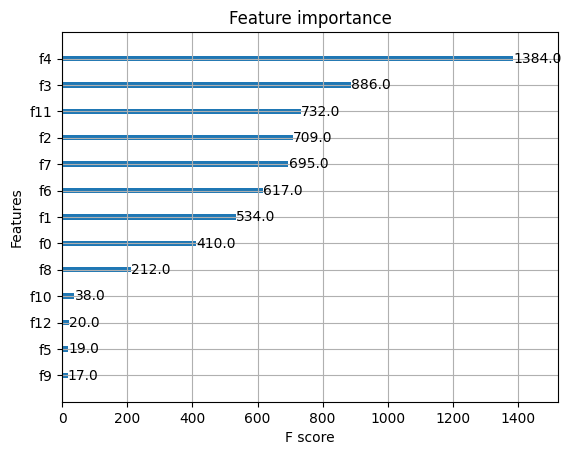

In [65]:
xgb.plot_importance(model4);

In [66]:
result4 = permutation_importance(
    model4, x_test_normalized, y_test_normalized, n_repeats=10, random_state=42, n_jobs=2
)

In [67]:
tree_importances4 = pd.Series(result4.importances_mean, index=feature_names)

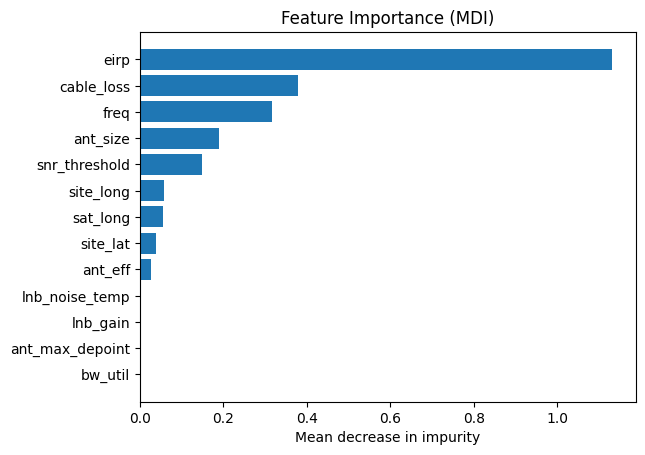

In [68]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances4)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances4[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

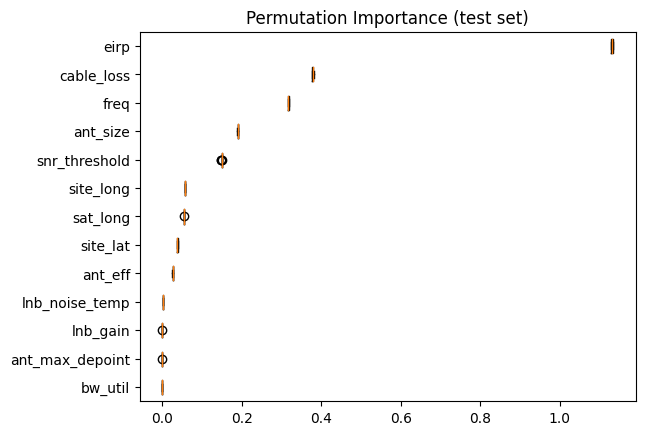

In [69]:
plt.boxplot(
    result4.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

In [70]:
model6 = VotingRegressor([("linear", model1), ("random-forest", model2), ("hist-grad-boost-reg", model3), ("xgb", model4)])  
model6.fit(x_train_normalized, y_train_normalized)

VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('random-forest', RandomForestRegressor()),
                            ('hist-grad-boost-reg',
                             HistGradientBoostingRegressor()),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [71]:
# save model
joblib.dump(model6, "voting_logout.joblib")

['voting_logout.joblib']

In [72]:
model6.score(x_test_normalized, y_test_normalized)

0.8654978799213717

In [73]:
predicted_availability6 = model6.predict(x_test_normalized)

In [74]:
mae6 = mean_absolute_error(y_test_normalized, predicted_availability6)
print('Voting test MAE = ', mae6)

Voting test MAE =  tf.Tensor(0.0013939775798583987, shape=(), dtype=float64)


In [75]:
mse6 = mean_squared_error(y_test_normalized, predicted_availability6)
rmse6 = mse6**.5
print('Voting test MSE = ', mse6)
print('Voting test RMSE = ', rmse6)

Voting test MSE =  tf.Tensor(4.988961919611426e-06, shape=(), dtype=float64)
Voting test RMSE =  tf.Tensor(0.002233598423981228, shape=(), dtype=float64)


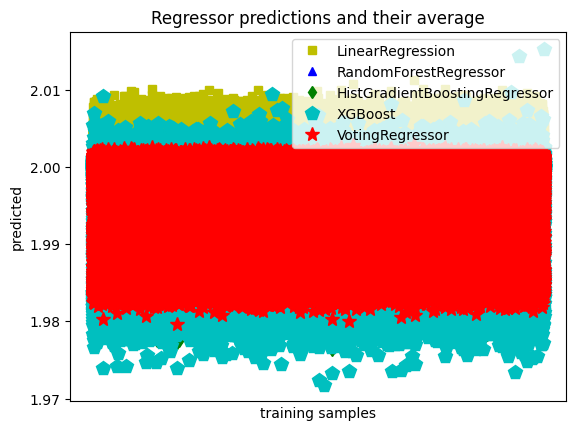

In [76]:
plt.figure()
plt.plot(predicted_availability1, "ys", label="LinearRegression")
plt.plot(predicted_availability2, "b^", label="RandomForestRegressor")
plt.plot(predicted_availability3, "gd", label="HistGradientBoostingRegressor")
plt.plot(predicted_availability4, "pc", ms=10, label="XGBoost")
plt.plot(predicted_availability6, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()